# LSRTM modelo personalizado

In [1]:
using PyPlot, JLD, SegyIO, JUDI, SlimOptim, Statistics, Random, LinearAlgebra, Dates, DelimitedFiles
t1 = now()

2023-07-07T20:21:25.286

In [2]:
M = load("model_custom_fwi_result_high_f.jld");
M2 = load("model_custom.jld")
model0 = Model(M2["n"], M2["d"], M2["o"], M2["m0"])
block = segy_read("model_custom_high_f_lin.segy")
dD = judiVector(block);

# Set up wavelet
src_geometry = Geometry(block; key="source", segy_depth_key="SourceDepth")
wavelet = ricker_wavelet(src_geometry.t[1],src_geometry.dt[1],0.025)	# 15 Hz wavelet
q = judiVector(src_geometry,wavelet)

# Set up info structure
ntComp = get_computational_nt(q.geometry,dD.geometry,model0)	# no. of computational time steps
info = Info(prod(model0.n),dD.nsrc,ntComp);

┌ Warning: Fixed length trace flag set in stream: IOBuffer(data=UInt8[...], readable=true, writable=false, seekable=true, append=false, size=4763124, maxsize=Inf, ptr=3601, mark=-1)
└ @ SegyIO /home/geopc3/.julia/packages/SegyIO/aQwou/src/read/read_file.jl:36


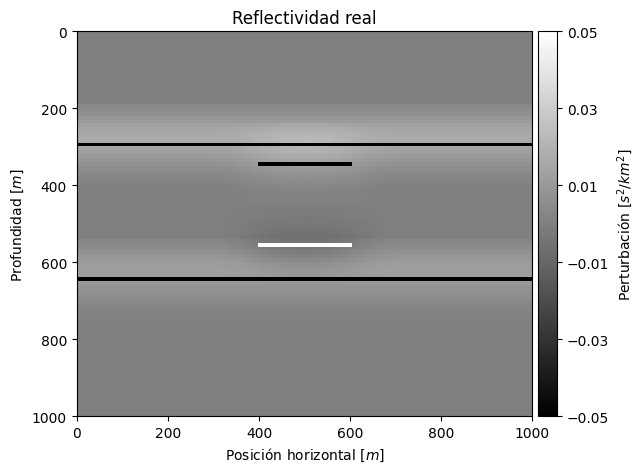

In [3]:
dm = vec(M2["m"]-M2["m0"]);
dm_ = reshape(dm, (101,101));

fig = figure(figsize=(7,5)); #, dpi=300
im = imshow(  diff(dm_, dims=2)', cmap="gray", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], vmin=-.05, vmax=.05, aspect="auto")
cb = colorbar(im, ticks=-0.05:0.02:0.05, pad=0.01)
cb[:set_label](label = L"Perturbación $[s^2/km^2]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("Reflectividad real")
display(fig)

In [4]:
# Set up matrix-free linear operators
opt = Options(optimal_checkpointing = true)    # set to false to disable optimal checkpointing
F = judiModeling(model0, q.geometry, dD.geometry; options=opt)
J = judiJacobian(F, q);

# Right-hand preconditioners (model topmute)
Mr = judiTopmute(model0; taperwidth=10)	# mute up to grid point 52, with 10 point taper
# Left-hand side preconditioners
Ml = judiDataMute(q.geometry, dD.geometry; t0=.120);	# data topmute starting at time 120ms

In [5]:
rtm = adjoint(J)*dD

Building forward operator
/home/geopc3/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/geopc3/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
Building adjoint born operator


PhysicalParameter{Float32} of size (101, 101) with origin (0.0, 0.0) and spacing (10.0, 10.0)


In [6]:
# Stochastic gradient
x = zeros(Float32, info.n)	# zero initial guess
batchsize = 10	# use subset of 10 shots per iteration
niter = 30
fval = zeros(Float32, niter) # misfit value
x_values = zeros(length(x), niter+1) # image iteration results
x_values[:, 1] = x

for j=1:niter
	println("Iteration: ", j)
	# Select batch and set up left-hand preconditioner
	i = randperm(dD.nsrc)[1:batchsize]

	# Compute residual and gradient
	r = Ml[i]*J[i]*Mr*x - Ml[i]*dD[i]
	g = adjoint(Mr)*adjoint(J[i])*adjoint(Ml[i])*r

	# Step size and update variable
	fval[j] = .5f0*norm(r)^2
	t = norm(r)^2/norm(g)^2
	global x -= t*g
	x_values[:, j+1] = x # save updated x to array
end

Iteration: 1
Iteration: 

2


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Building born operator
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s


Iteration: 3


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s


Iteration: 4


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s


Iteration: 5


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s


Iteration: 6


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s


Iteration: 7


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s


Iteration: 8


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s


Iteration: 9


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s


Iteration: 10


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s


Iteration: 11


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s


Iteration: 12


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s


Iteration: 13


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s


Iteration: 14


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s


Iteration: 15


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s


Iteration: 16


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s


Iteration: 17


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s


Iteration: 18


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s


Iteration: 19


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s


Iteration: 20


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s


Iteration: 21


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s


Iteration: 22


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s


Iteration: 23


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.04 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.03 s


Iteration: 24


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s


Iteration: 25


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s


Iteration: 26


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s


Iteration: 27


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s


Iteration: 28


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s


Iteration: 29


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s


Iteration: 30


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s


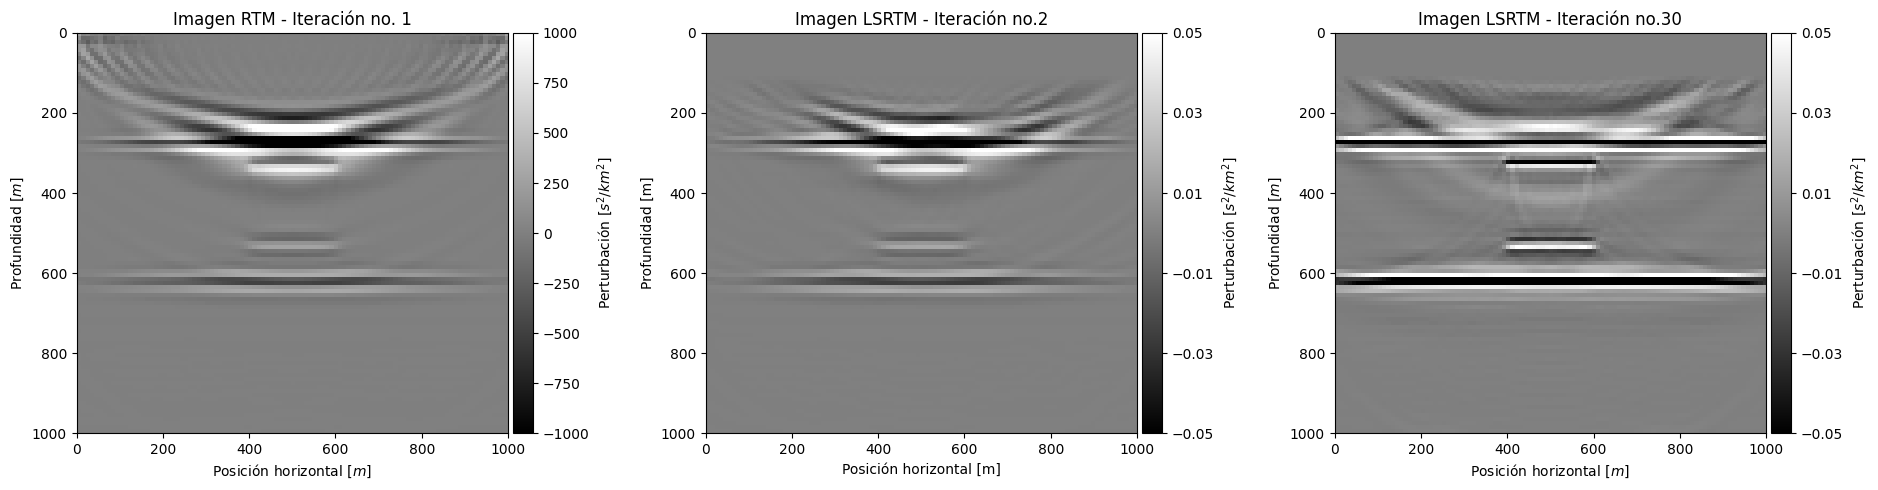

In [7]:
fig=figure(figsize=(19,5)); #, dpi=300
subplot(131)
im = imshow(diff(rtm.data, dims=2)', vmin=-1e3, vmax=1e3, cmap="gray", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], aspect="auto")
cb = colorbar(im, pad=0.01)
cb[:set_label](label = L"Perturbación $[s^2/km^2]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("Imagen RTM - Iteración no. 1")
subplot(132)
im = imshow(diff(reshape(x_values[:, 2], (101,101)), dims=2)', vmin=-0.05, vmax=0.05, cmap="gray", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], aspect="auto")
cb = colorbar(im, pad=0.01, ticks=-0.05:0.02:0.05)
cb[:set_label](label = L"Perturbación $[s^2/km^2]$")
xlabel("Posición horizontal [m]")
ylabel("Profundidad [m]")
title("Imagen LSRTM - Iteración no.2")
subplot(133)
im = imshow(diff(reshape(x_values[:, 31], (101,101)), dims=2)', vmin=-0.05, vmax=0.05, cmap="gray", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], aspect="auto")
cb = colorbar(im, pad=0.01, ticks=-0.05:0.02:0.05)
cb[:set_label](label = L"Perturbación $[s^2/km^2]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("Imagen LSRTM - Iteración no.30")
tight_layout()
display(fig)

In [8]:
fhistory_SGD = fval/norm(fval, Inf);

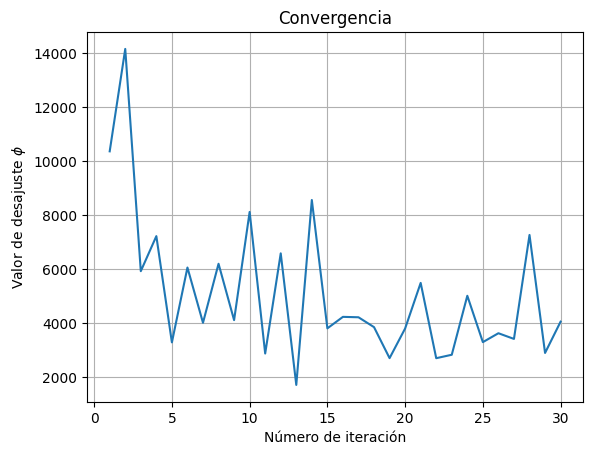

In [9]:
fig = figure()#dpi=300)
xax = 1:1:30
plot(xax,fval[1:30])
#scatter(45,fval[45], color="black")
xlabel("Número de iteración")
ylabel(L"Valor de desajuste $\phi$")
title("Convergencia")
grid()
display(fig)

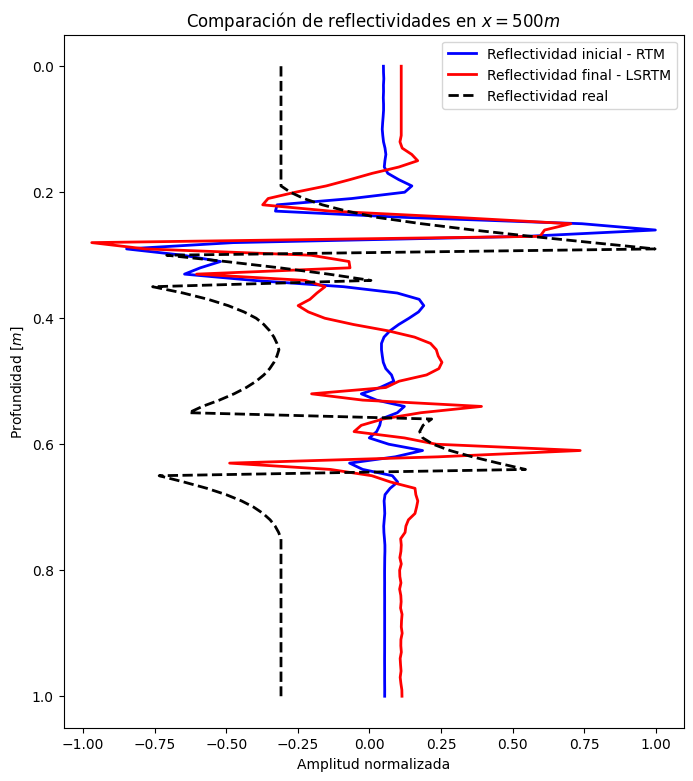

In [10]:
fig = figure(figsize=(8,9))#, dpi=300)
xax = 0:0.01:1
rtm_norm=reshape((rtm.data .- minimum(rtm.data)) ./ (maximum(rtm.data) .- minimum(rtm.data)) .* 2 .- 1, (101,101)); 
x_norm=reshape((x_values[:, 31] .- minimum(x_values[:, 31])) ./ (maximum(x_values[:, 31]) .- minimum(x_values[:, 31])) .* 2 .- 1, (101,101));
dm_true_norm=reshape((dm_ .- minimum(dm_)) ./ (maximum(dm_) .- minimum(dm_)) .* 2 .- 1, (101,101));
plot(rtm_norm[50,:], xax, linewidth=2, label="Reflectividad inicial - RTM", "b")
plot(x_norm[50,:], xax, linewidth=2, label="Reflectividad final - LSRTM", "r")
plot(dm_true_norm[50,:], xax, linewidth=2, label="Reflectividad real", "k--")
legend()
gca().invert_yaxis()
xlabel("Amplitud normalizada")
ylabel(L"Profundidad $[m]$")
title(L"Comparación de reflectividades en $x=500m$")
display(fig)

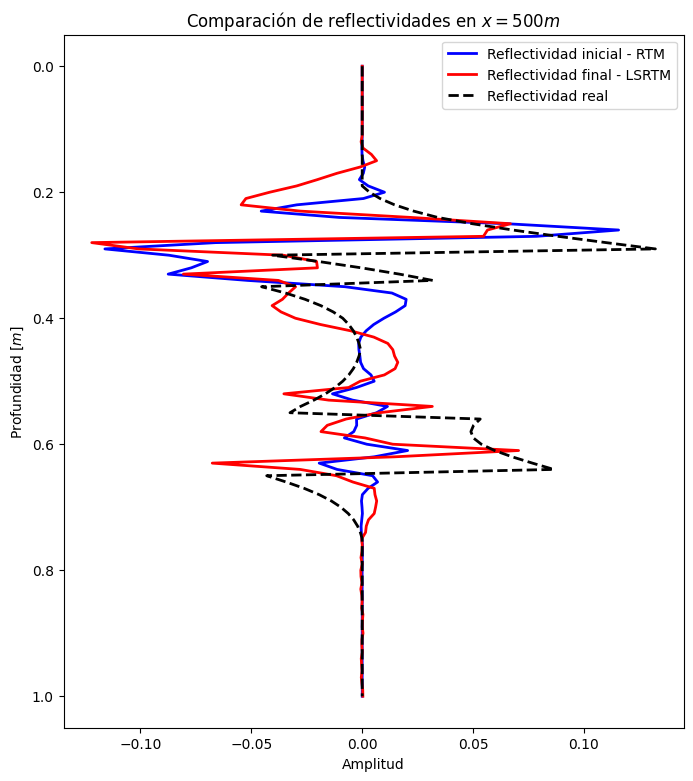

In [16]:
fig = figure(figsize=(8,9))#, dpi=300)
xax = 0:0.01:1
dm_true=reshape(dm_, (101,101));
rtm50=reshape(x_values[:, 2], (101,101)) # tomamos la primera iteracion
lsrtmf=reshape(x_values[:, 31], (101,101)) # tomamos la primera iteracion
plot(rtm50[50,:], xax, linewidth=2, label="Reflectividad inicial - RTM", "b")
plot(x[50,:], xax, linewidth=2, label="Reflectividad final - LSRTM", "r")
plot(dm_true[50,:], xax, linewidth=2, label="Reflectividad real", "k--")
legend()
gca().invert_yaxis()
xlabel("Amplitud")
ylabel(L"Profundidad $[m]$")
title(L"Comparación de reflectividades en $x=500m$")
display(fig)

In [12]:
writedlm("lsrtm_results/rtm.txt", rtm.data)
writedlm("lsrtm_results/lsrtm.txt", x_values)
writedlm("lsrtm_results/dmtrue.txt", dm_)
writedlm("lsrtm_results/fval.txt", fval)

In [13]:
t2 = now()

2023-07-07T20:33:14.321

In [14]:
t2-t1

709035 milliseconds

In [15]:
canonicalize(t2 - t1)

11 minutes, 49 seconds, 35 milliseconds